# Predicting Box Office Performance Based on Audience Sentiment

## Introduction

In this project, we aim to predict a movie’s box office performance by analyzing historical movie data and sentiment data from social media. Specifically, we will:

- Use a historical dataset of movies that includes their budgets, genres, ratings, and lifetime revenues.
- Perform sentiment analysis on tweets about a target movie ("Smile 2") to gauge the public’s initial reaction.
- Engineer features, train regression models (Random Forest, Gradient Boosting, XGBoost), and predict the target movie’s revenue.
- Visualize relationships between features and outcomes.

**Data Files:**
- `data/historical_movies.csv`: Contains historical movie data with columns:  
  - Title, Rating, Budget, Genre, Lifetime_Revenue
- `data/smile2_tweets.csv`: Tweets about "Smile 2".

**Assumptions:**
- "Smile 2" budget and genre are hardcoded.
- We assume "Smile 2" belongs primarily to the Horror genre.

**Final Goal:**
Predict the lifetime revenue for "Smile 2" based on historical patterns and the sentiment extracted from recent tweets.

## 1. Import Dependencies

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.linear_model import Ridge
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Data Loading

We will load:
- `historical_movies.csv`
- `smile2_tweets.csv`


In [11]:
# Load the historical data
hist_df = pd.read_csv('data/historical_movies.csv')

# Load the tweets data for Smile 2
tweets_df = pd.read_csv('data/smile2_tweets.csv')


### Quick Glance at Historical Data

In [12]:
hist_df.head()

,Title,Rating,Budget,Genre,Lifetime_Revenue
0,Dear John,6.3,25000000.0,"Drama, Romance, War","$80,014,842"
1,Valentine's Day,5.7,52000000.0,"Comedy, Romance","$110,528,528"
2,Shutter Island,8.2,80000000.0,"Drama, Mystery, Thriller","$128,012,934"
3,Alice in Wonderland,6.4,200000000.0,"Adventure, Family, Fantasy","$334,191,110"
4,How to Train Your Dragon,8.1,165000000.0,"Animation, Action, Adventure","$217,581,231"


### Quick Glance at Tweets Data

In [13]:
tweets_df.head()

,Name,Handle,Timestamp,Verified,Content,Comments,Retweets,Likes,Analytics,Tags,Mentions,Emojis,Profile Image,Tweet Link,Tweet ID
0,When We Speak TV,@whenwespeaktv,2024-10-16T23:59:13.000Z,False,Smile 2 Is Even Better than the First!!! #Smil...,0,0,0,206,"['#Smile2', '#SmileMovie']",['@SmileMovie'],[],https://pbs.twimg.com/profile_images/126864241...,https://x.com/whenwespeaktv/status/18467024696...,tweet_id:1846702469646024756
1,Alex: Romulus,@Alex_Madden_,2024-10-16T23:55:53.000Z,False,Once again I am afraid of smiles. Check out my...,0,0,0,170,"['#Smile2', '#smilemovie']",[],[],https://pbs.twimg.com/profile_images/167528132...,https://x.com/Alex_Madden_/status/184670163040...,tweet_id:1846701630407790651
2,Sabrina,@SabrinaSpectre,2024-10-16T23:52:34.000Z,False,Is #Smile2 the new Final Destination franchise?,0,0,0,81,['#Smile2'],[],[],https://pbs.twimg.com/profile_images/184650112...,https://x.com/SabrinaSpectre/status/1846700795...,tweet_id:1846700795393151357
3,Flickreel,@Flickreel,2024-10-16T23:50:07.000Z,False,#Smile2 feels like a prominent turning point f...,0,0,0,228,['#Smile2'],['@SmileMovie'],[],https://pbs.twimg.com/profile_images/489717960...,https://x.com/Flickreel/status/184670017977838...,tweet_id:1846700179778388461
4,Nicholas Spake,@NSpake,2024-10-16T23:49:27.000Z,False,#Smile2 feels like a prominent turning point f...,0,0,0,110,['#Smile2'],['@SmileMovie'],[],https://pbs.twimg.com/profile_images/110968796...,https://x.com/NSpake/status/1846700013709132061,tweet_id:1846700013709132061


## 3. Data Cleaning & Feature Engineering (Historical Data)

**Steps:**
- Convert Lifetime_Revenue to numeric (remove $, commas).
- Handle missing Ratings (if any).
- Derive a sentiment score from the Rating.
- Encode genres and calculate interactions.
- Drop rows with missing data where required.


In [14]:
### Data Cleaning & Feature Engineering (Historical Data)

# Clean Lifetime_Revenue
hist_df['Lifetime_Revenue'] = hist_df['Lifetime_Revenue'].str.replace('$','', regex=False)
hist_df['Lifetime_Revenue'] = hist_df['Lifetime_Revenue'].str.replace(',','', regex=False)
hist_df['Lifetime_Revenue'] = pd.to_numeric(hist_df['Lifetime_Revenue'], errors='coerce')

# Handle Ratings
hist_df['Rating'] = pd.to_numeric(hist_df['Rating'], errors='coerce')
hist_df['Rating'].fillna(hist_df['Rating'].median(), inplace=True)

# Continuous mapping of rating to sentiment
# Ratings assumed 0-10 scale, so divide by 10
# If IMDB is 0-10, this works directly. If it's actually 0-10 scale, perfect.
# If it's 0-10.0 as the extracted rating, this should be fine. 
hist_df['Derived_Sentiment'] = hist_df['Rating'] / 10.0

# Drop rows with missing revenue if any
hist_df.dropna(subset=['Lifetime_Revenue'], inplace=True)

# Genre Encoding
# Split genre by comma and strip spaces
hist_df['Genre'] = hist_df['Genre'].fillna('')
hist_df['MovieGenreList'] = hist_df['Genre'].apply(lambda x: [g.strip() for g in str(x).split(',') if g.strip() != ''])
all_genres = set([g for glist in hist_df['MovieGenreList'] for g in glist])

# Create a column for each genre
for g in all_genres:
    hist_df[f'Genre_{g}'] = hist_df['MovieGenreList'].apply(lambda x: 1 if g in x else 0)

# We now have multiple genre columns. We no longer need Genre_Similarity since we have full encoding.
# But we know Smile 2 is Horror, so maybe that matters. Let's keep track:
# Actually, we can let the model learn from Genre_Horror as a feature for Smile 2.

hist_df.head()

,Title,Rating,Budget,Genre,Lifetime_Revenue,Derived_Sentiment,MovieGenreList,Genre_War,Genre_Mystery,Genre_Sci-Fi,...,Genre_Documentary,Genre_Crime,Genre_Animation,Genre_Fantasy,Genre_Music,Genre_Comedy,Genre_Romance,Genre_Thriller,Genre_History,Genre_Action
0,Dear John,6.3,25000000.0,"Drama, Romance, War",80014842.0,0.63,"[Drama, Romance, War]",1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,Valentine's Day,5.7,52000000.0,"Comedy, Romance",110528528.0,0.57,"[Comedy, Romance]",0,0,0,...,0,0,0,0,0,1,1,0,0,0
2,Shutter Island,8.2,80000000.0,"Drama, Mystery, Thriller",128012934.0,0.82,"[Drama, Mystery, Thriller]",0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,Alice in Wonderland,6.4,200000000.0,"Adventure, Family, Fantasy",334191110.0,0.64,"[Adventure, Family, Fantasy]",0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,How to Train Your Dragon,8.1,165000000.0,"Animation, Action, Adventure",217581231.0,0.81,"[Animation, Action, Adventure]",0,0,0,...,0,0,1,0,0,0,0,0,0,1


## 4. Sentiment Analysis of Tweets for "Smile 2"

We use VADER to calculate sentiment scores for tweets.


In [15]:
analyzer = SentimentIntensityAnalyzer()

def get_vader_sentiment(text):
    vs = analyzer.polarity_scores(str(text))
    return vs['compound']  # compound gives a normalized score between -1 and 1

tweets_df['Sentiment'] = tweets_df['Content'].apply(get_vader_sentiment)
smile2_avg_sentiment = tweets_df['Sentiment'].mean()

# Improved sentiment mapping for Smile 2:
# Now that we have a continuous sentiment (compound), we could directly use it.
# But for consistency, let's still map tweet sentiment to derived sentiment scale (0.2 to 0.8)
# Or we can directly use the compound score as Derived_Sentiment for Smile 2.
# Let's directly use the compound score as Derived_Sentiment for Smile2 this time 
# to be more consistent with continuous scales.

smile2_derived_sentiment = smile2_avg_sentiment  # now directly a continuous value between -1 and 1
# We'll handle scaling later, so no manual bins now.

smile2_budget = 25000000.0

smile2_derived_sentiment

0.1386514

**Interpretation:**
This sentiment score will represent the public’s initial reaction to "Smile 2". Values close to 1 indicate more positive sentiment, -1 more negative, and 0 neutral.

## 5. Preparing Features for Modeling

For the historical movies:
- Features: Budget, Derived_Sentiment, Genre_Similarity
- Target: Lifetime_Revenue

For "Smile 2", we will use:
- Budget (hardcoded: 25,000,000)
- Derived_Sentiment from tweets (smile2_avg_sentiment)
- Genre_Similarity (1 since its main genre is horror)

We may also consider interactions, but let's keep it simple.


In [16]:
# Log transform Budget and Lifetime_Revenue
hist_df['Budget'] = pd.to_numeric(hist_df['Budget'], errors='coerce')
hist_df['Budget_log'] = np.log1p(hist_df['Budget'])           # log(1+Budget)

hist_df['Lifetime_Revenue'] = pd.to_numeric(hist_df['Lifetime_Revenue'], errors='coerce')
hist_df['Lifetime_Revenue_log'] = np.log1p(hist_df['Lifetime_Revenue']) # log(1+Revenue)

# Ensure Derived_Sentiment is numeric
hist_df['Derived_Sentiment'] = pd.to_numeric(hist_df['Derived_Sentiment'], errors='coerce')

# Identify genre columns
genre_cols = [c for c in hist_df.columns if c.startswith('Genre_')]

# Interaction: Budget * Derived_Sentiment
hist_df['BudgetSentiment'] = hist_df['Budget_log'] * hist_df['Derived_Sentiment']

# Interaction with genres: Budget_log * each Genre
for gc in genre_cols:
    # Ensure the genre columns are numeric (they should be already)
    hist_df[gc] = pd.to_numeric(hist_df[gc], errors='coerce').fillna(0).astype(int)
    hist_df[f'Budget_{gc}'] = hist_df['Budget_log'] * hist_df[gc]

# Prepare feature matrix and target
feature_cols = (
    ['Budget_log', 'Derived_Sentiment', 'BudgetSentiment'] 
    + genre_cols 
    + [f'Budget_{gc}' for gc in genre_cols]
)
X = hist_df[feature_cols]
y = hist_df['Lifetime_Revenue_log']

# Scaling and Modeling with Cross-Validation and Grid Search
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='rmse')
}

param_grids = {
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [None, 10]
    },
    'GradientBoosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 0.05]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.1, 0.05]
    }
}

best_models = {}
scaler = StandardScaler()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(r2_score)

for name, model in models.items():
    pipe = Pipeline([
        ('scaler', scaler),
        ('model', model)
    ])
    grid = GridSearchCV(pipe, param_grids[name], cv=kf, scoring=scorer, n_jobs=-1)
    grid.fit(X, y)
    best_models[name] = grid.best_estimator_


# Ensemble the best models
voting_reg = VotingRegressor(estimators=[(n, m) for n, m in best_models.items()])
voting_reg.fit(X, y)  # Train on the full data

# Final evaluation on a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
voting_reg.fit(X_train, y_train)
y_pred = voting_reg.predict(X_test)
r2 = r2_score(y_test, y_pred)
r2


/Users/edaad/Desktop/JuniorYear/CS506/finalproject/cs506-final-project/venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edaad/Desktop/JuniorYear/CS506/finalproject/cs506-final-project/venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edaad/Desktop/JuniorYear/CS506/finalproject/cs506-final-project/venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [15:03:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/edaad/Desktop/JuniorYear/CS506/finalproject/cs506-final-project/venv/lib/python3.11/site-p

0.5317493015693253

**Model R² Score Interpretation:**
The R² score indicates how well our model fits the data. A higher value (closer to 1) means a better fit. Since this is a mock scenario, any positive value shows we can at least do some prediction.


## 6. Predicting "Smile 2" Box Office Revenue

Now we use:
- Budget = 25,000,000
- Derived Sentiment = smile2_avg_sentiment (from tweets)
- Genre_Similarity = 1 (Horror)

In [17]:
# When constructing smile2_data, follow the same logic:
smile2_data = {}
smile2_data['Budget_log'] = np.log1p(smile2_budget)
smile2_data['Derived_Sentiment'] = smile2_derived_sentiment
smile2_data['BudgetSentiment'] = smile2_data['Budget_log'] * smile2_data['Derived_Sentiment']

for g in all_genres:
    if g == 'Horror':
        smile2_data[f'Genre_{g}'] = 1
    else:
        smile2_data[f'Genre_{g}'] = 0

# Create Budget_{gc} for each genre column
for gc in genre_cols:
    smile2_data[f'Budget_{gc}'] = smile2_data['Budget_log'] * smile2_data[gc]

smile2_features = pd.DataFrame([smile2_data])[feature_cols]
smile2_pred_log = voting_reg.predict(smile2_features)[0]
smile2_pred = np.expm1(smile2_pred_log)
smile2_pred


40035028.905235514

**Interpretation:**
The predicted revenue for "Smile 2" is just a numeric output from our model. This is a rough estimate based on historical data and sentiment.

## 7. Data Visualization

We’ll create a few plots:
- Scatter plot of Derived_Sentiment vs. Revenue.
- Histograms of Revenue Before and After Log Transform
- Top 10 Feature Importances (Bar Chart from RandomForest)


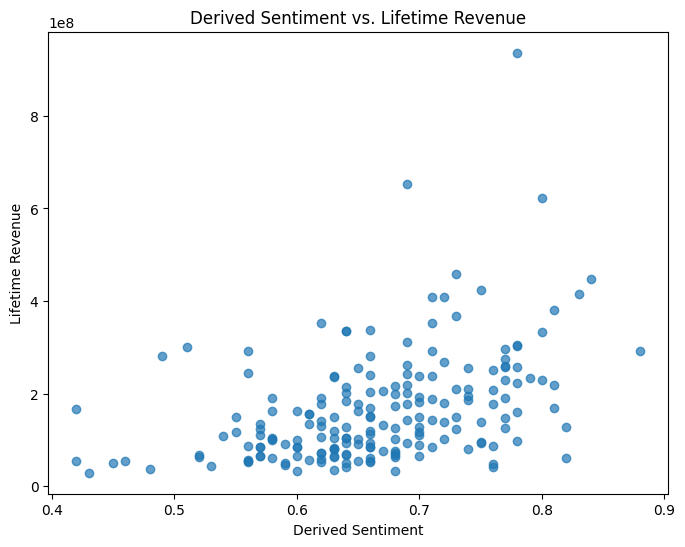

In [18]:
plt.figure(figsize=(8,6))
plt.scatter(hist_df['Derived_Sentiment'], np.expm1(hist_df['Lifetime_Revenue_log']), alpha=0.7)
plt.xlabel("Derived Sentiment")
plt.ylabel("Lifetime Revenue")
plt.title("Derived Sentiment vs. Lifetime Revenue")
plt.show()

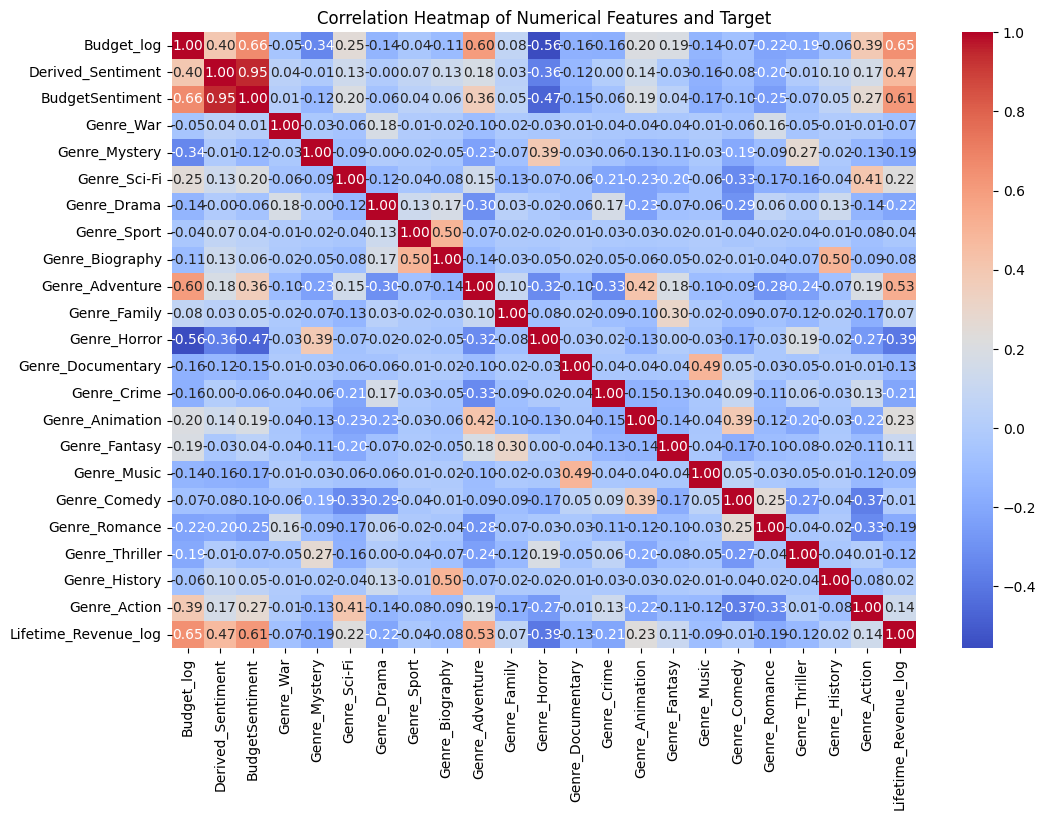

In [19]:
# Compute correlation matrix for numerical features
numerical_cols = ['Budget_log', 'Derived_Sentiment', 'BudgetSentiment'] + genre_cols
correlation_matrix = hist_df[numerical_cols + ['Lifetime_Revenue_log']].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numerical Features and Target")
plt.show()


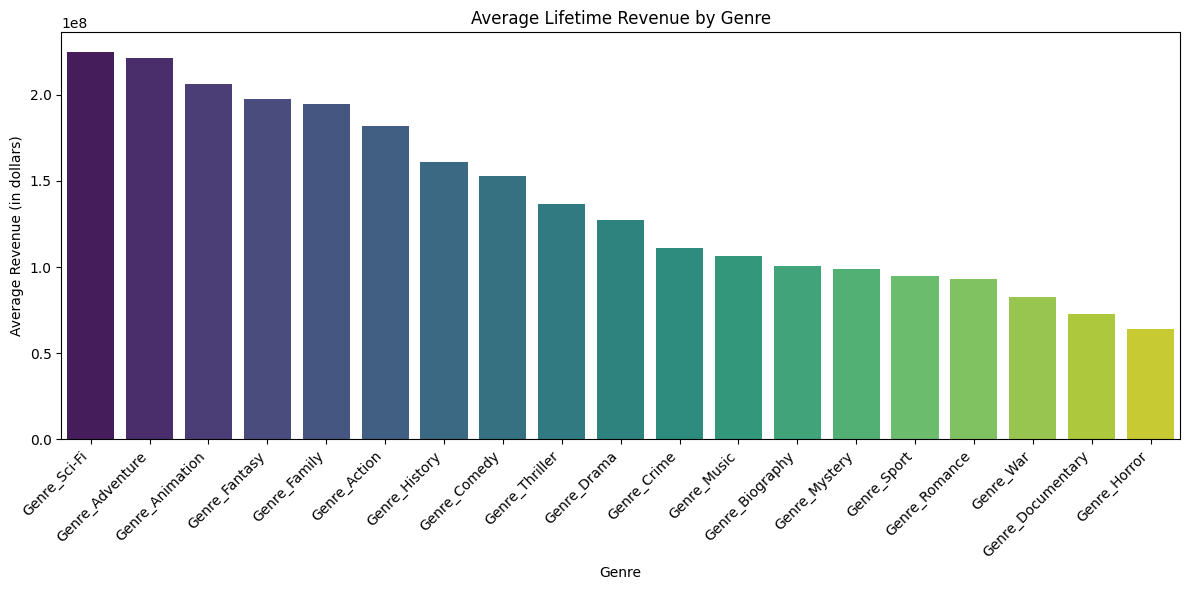

In [20]:
# Compute average revenue for each genre
genre_revenue = {}
for genre in genre_cols:
    avg_revenue = hist_df.loc[hist_df[genre] == 1, 'Lifetime_Revenue'].mean()
    genre_revenue[genre] = avg_revenue

# Create a sorted DataFrame
genre_revenue_df = pd.DataFrame.from_dict(genre_revenue, orient='index', columns=['Average_Revenue'])
genre_revenue_df.sort_values(by='Average_Revenue', ascending=False, inplace=True)

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_revenue_df.index, y=genre_revenue_df['Average_Revenue'], palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Average Lifetime Revenue by Genre")
plt.ylabel("Average Revenue (in dollars)")
plt.xlabel("Genre")
plt.tight_layout()
plt.show()


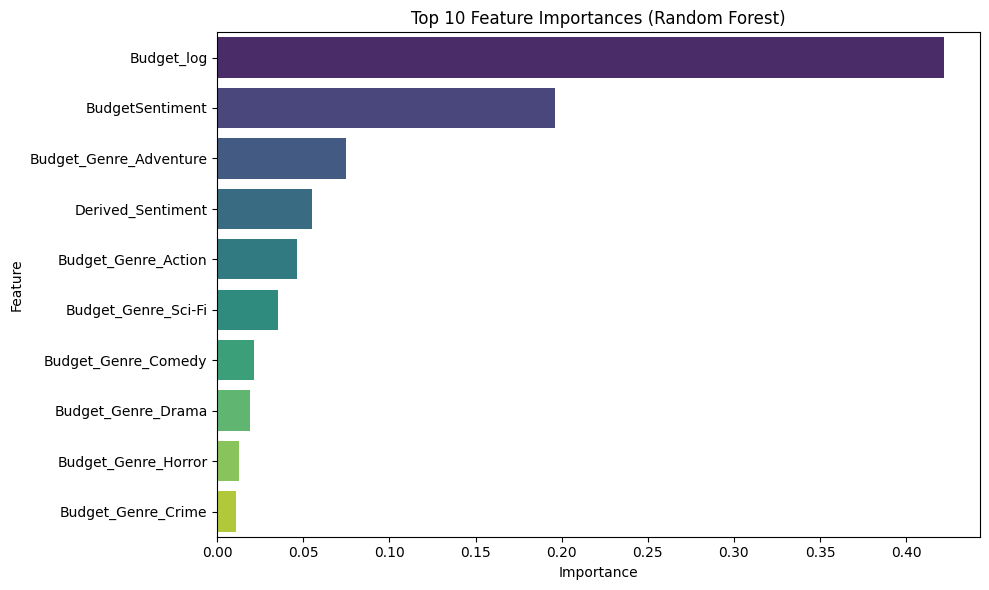

In [21]:
importances = best_models['RandomForest'].named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1]  # sort features by importance descending

top_10 = indices[:10]
plt.figure(figsize=(10,6))
sns.barplot(x=importances[top_10], y=np.array(feature_cols)[top_10], orient='h', palette='viridis')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 8. Conclusion

We developed a simple pipeline:
- Loaded historical data and tweets.
- Performed sentiment analysis on tweets for "Smile 2".
- Engineered features from historical data (rating-based sentiment, genre similarity).
- Trained a regression model and predicted "Smile 2" revenue.
- Visualized relationships between features and revenue.

**Limitations & Future Work:**
- The model and features are very simplistic.
- We assumed "Smile 2" genre and budget.
- The sentiment mapping from tweets to derived sentiment was arbitrary.
- Future iterations could incorporate more complex NLP techniques, more comprehensive datasets, and additional features like audience demographics or marketing spend.

Overall, this demonstrates the data science lifecycle: data collection, cleaning, feature engineering, modeling, evaluation, and visualization.

In [ ]:
import joblib

# Save the trained model and features
joblib.dump(voting_reg, 'model/voting_reg.pkl')
joblib.dump({'genre_cols': genre_cols, 'feature_cols': feature_cols}, 'model/features.pkl')


['model/features.pkl']